<a href="https://colab.research.google.com/github/comp0161/tutorials/blob/main/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0161 Auditory Computing Week 3: Digital Signal Processing

In this week's tutorial session we'll look at some of the practical considerations when dealing with sound, a fundamentally **analogue** phenomenon, on **digital** computers.

In this and several future sessions we will make use of [Google's Colab computing environment](https://colab.research.google.com/#). If you have not used Colab before you can read about it [here](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). A very brief summary of what you need to know can be found in the section below. Feel free to skip this if you are already familiar with Colab.

Although this is not primarily a programming exercise, we will be using [Python](https://docs.python.org/3/tutorial/index.html) to demonstrate various concepts, including some details on implementation. All code is provided, so you should be able to follow along even if you are unfamiliar with Python, but you may find some of the more implementation-oriented sections a bit obscure.

## Using Colab

Colab provides free access to Google computational resources via a web-based front end known as a **notebook**. The notebook content is broken down into **cells**, of which there are two basic types:
* **Text** cells (like this one) contain rich text and possibly other media such as images. You should **read** the content of these cells!
* **Code** cells (like the one below) contain program instructions in Python, and sometimes other operating system commands. The latter are typically prefixed by an exclamation mark, like this: `!ls -l`
   
   Code content can be executed on the remote **virtual machine** by clicking on the **play**  ( ▶︎ ) button that appears in the top left hand corner of the cell when you move your cursor over it. Some code may take a while to run — the play button will change to a **stop** (◾️) button, and an animated progress wheel will show around it. As the code runs, it may produce output, which will appear at the bottom of the cell. You can click the stop button to halt the execution.

  (The notebook must be **connected** to a virtual machine in order to run code cells. This should happen automatically the first time you attempt to execute a cell — there will be a delay while this takes place.)

Try clicking the play button on the cell below to run it.

In [ ]:
# a very simple example of a code cell
# running the cell will execute the statement below and generate output
print('hello world!')

hello world!


There are two important caveats to be aware of, one to do with the Jupyter notebook interface and the other to do with Colab:

1. The notebook interface allows **out of order execution** of code cells. That is, it is possible to run later cells before earlier ones. This is really **never what you want** and can give rise to all kinds of problems with inconsistent state. Always be sure to run cells in order. If you need to go back and re-run earlier cells (eg, because you want to change something) always follow that up by re-running all the subsequent cells in order too, to make sure everything is consistent.

2. The virtual machine environment that Colab runs behind this notebook interface is **resource-limited** and **transient**. If you don't do anything for awhile, the notebook may disconnect from the virtual machine. If you use too much computation then your session may be halted — and what qualifies as "too much" is kept intentionally vague. VMs are purged daily: if you stop and come back to it tomorrow the VM will have been deleted and you will need to go back to the beginning and go through the setup steps again. If you generate something that you want to keep, you should download it to your local machine.


# Setting Up

We're not going to be doing anything very specialised this week, so we only need a few standard libraries:

* [NumPy](https://numpy.org/doc/stable/) is a library for numerical computing, in particular providing efficient and convenient handling of vectors and multidimensional arrays of numeric data.
* [SciPy](https://docs.scipy.org/doc/scipy/index.html) is a library for scientific computing. It's built on top of NumPy but implements lots of additional functionality. In particular, the subpackages [`scipy.fft`](https://docs.scipy.org/doc/scipy/tutorial/fft.html) and [`scipy.signal`](https://docs.scipy.org/doc/scipy/tutorial/signal.html) provide algorithms useful for digital signal processing.
* [MatPlotLib](https://matplotlib.org/stable/users/index) provides plotting functionality so we can visualise our data.
* [IPython.display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html) provides display elements for the web-based notebook itself. In particular, the `Audio` class will allow us to insert sound data into the web page as playable widgets.

These are all available by default on the Colab VMs, so we don't need to install them explicitly. We just need to tell the Python interpreter we're going to use them.

In [ ]:
import numpy as np
import scipy.signal as ssg
import scipy.fft as fft
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image, Audio

# we'll be wanting some random numbers later
# we create a generator with a fixed seed for consistent behaviour
# if you want different results, change the seed
SEED = 9907
rng = np.random.default_rng(SEED);

# Analogue vs Digital



As discussed in week 1, sounds are vibrations in a material medium — usually air for the purposes of human hearing. These vibrations are necessarily **continuous**. Particles of matter move back and forth in space. They cannot teleport instantaneously from one place to another, they must pass through every point in between at finite speeds.

Computers, on the other hand, are innately **discrete**. They divide the world up into separate numbers, logical states, ones and zeros. (Analogue computation is possible, and used to be widespread, but is rarely encountered in modern technology — we live in an overwhelmingly **digital** age.) A collection or sequence of numbers on a computer is discontinuous — there is nothing between one number and the next, no space or time to pass through.

In order to deal with sound computationally, therefore, we need to represent it with discrete numbers. There are many ways to do this — even this text can be considered as an (approximate) encoding of the sounds of speech — and we'll touch on some others later in the module. But for the moment we'll focus on by far the most common approach, known (somewhat cryptically) as [pulse code modulation](https://en.wikipedia.org/wiki/Pulse-code_modulation) or PCM. This represents the continuous audio signal by measuring — **sampling** — its vibrational displacement at regular intervals.

<details>
<summary>Note</summary>
<p>The relationship between measured samples and the actual amplitude of physical vibration depends on the equipment used for recording and playback and on all kinds of contextual details that we won't even try to think about here. Samples in a PCM file are abstractions derived from the physical sound rather than a perfect representation of it, but it can helpful to conceptualise them as simple measurements of position.
</p>
</details>

# Sampling

Measuring a continuous path via periodic samples is an inexact business, at least in the absence of additional constraints. You may measure that the air was displaced to point $x_t$ at time $t$ and point $x_{t+1}$ at time $t+1$, but you can't be sure where it was in between.

<details>
<summary>Note</summary>
<p>The examples below illustrating issues with digital sampling of analogue signals are, of course, themselves digital, and hence subject to the same considerations being discussed. The fact that they nevertheless work may be taken as a reassuring demonstration that digital signal processing is viable. This would be a pretty short module otherwise.
</p>
</details>

Consider the figure generated by the following code:

In [ ]:
tt = np.linspace(0, 2 * np.pi, 601)
x1 = np.sin(tt * 2)
x2 = np.sin(tt * 10)

plt.plot(tt, x1)
plt.plot(tt, x2)

idx = np.arange(0, 601, 75)
plt.plot(tt[idx], x1[idx], linestyle='', marker='o', color='k')
plt.xlabel("Time")
plt.ylabel("Displacement");

Suppose we collect the sequence of samples indicated by the black dots. These could be generated by the lower frequency oscillation indicated by the blue line, but could also result from the higher frequency orange line. Or indeed a more or less infinite variety of other sound waves. So how can we determine which is correct?

In general this problem is actually impossible — there is no way to distinguish between these two signals given the samples.

However, we *can* uniquely reconstruct a signal if we impose the following condition: all of the frequencies present in the signal must be lower than half the sampling frequency — that is, the rate at which we take measurements.

This is known as the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), and it has two key practical implications:

* If you want to be able to capture higher frequency content, you need to use a higher sampling rate.
* Whatever sampling rate you use, you should ensure your signal does not contain any frequencies higher than the rate can safely capture.

To see the second point, consider the figure again. The sampling rate is high enough to accurately capture the blue signal — the samples uniquely determine that curve as long as the frequency constraint holds. But if the orange signal is actually present instead — in violation of the constraint — the reconstruction will be wrong. The samples will be interpreted as the blue signal, when that isn't present.

This is known as **aliasing**: when high frequency components outside the representable bandwidth are incorrectly mapped to lower frequencies that can be represented but shouldn't be there. These will often manifest as harsh discordant overtones, distortion and noise.

Ensuring that unwanted high frequencies are not present is not always straightforward. For recording, it is common to use an **anti-aliasing filter** to attenuate these higher frequencies. (We'll come back to filtering shortly.) When synthesising signals digitally, it's surprisingly easy to violate the bandwidth constraints and generate an ugly racket.

Human hearing ranges up to about 20kHz. We can see from the sampling theorem that adequately capturing that range requires a sampling rate greater than about 40kHz, which is why the most commonly used audio rates are 44.1kHz and 48kHz. That's a lot of samples per second, and can turn into an awful lot of data over time, so lower rates are sometimes used, sacrificing frequency range for smaller files in a crude form of compression. (We'll use 22.05kHz below.)

More sophisticated audio compression methods are employed in formats like MP3 and AAC. These are **lossy**, meaning they again sacrifice a bunch of detail, but they do so in a way that is carefully informed by **psychophysics** — trying to maintain as much of the perceptually important content as possible and throwing out stuff that the brain doesn't care much about anyway. It turns out that the brain doesn't care about quite a lot.

It's worth noting that, while sampled digital data is great for computers, it's fundamentally meaningless to humans. Our auditory systems are just as analogue as the original vibrations, so eventually we'll want to turn those PCM samples back into physical sound. Sound generating devices like loudspeakers and headphones ultimately require an analogue signal again — a fluctuating voltage — to drive the speaker cone and vibrate the air. Turning the sequence of discrete sample values into such a signal is the job of a **digital to analogue converter** or DAC. Generally this will entail another round of filtering to, as it were, *file off the sharp edges* of the digital signal and force it to move smoothly through the continuous material world again.

# Spectra

You might have noticed that in the aliasing example we considered only simple sine waves. Indeed the signal frequencies mentioned in the sampling theorem are also sinusoids. You'll recall from week 1 that sine waves sound pretty dull and we'll certainly want to capture and play more complex waveforms.

Fortunately, as Ifat discussed in the lectures — and you probably knew already — any periodic oscillation, no matter how complex, can be considered as the sum of (perhaps infinitely many) sinusoids of different frequencies, phases and amplitudes. Decomposing the original (**time domain**) signal into its **frequency domain** components is the job of a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform). In the computational context that means a [Discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (DFT), almost invariably in the form of a [Fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) or FFT.

FFTs are important and useful, but can be unintuitive and fiddly in practice and we're only going to skate over the surface here. If you're interested, there's plenty more detail in the [`scipy.fft` user guide](https://docs.scipy.org/doc/scipy/tutorial/fft.html).

The basic usage is fairly straightforward. Let's first generate a signal. The `scipy.signal` package provides several useful functions for this. Here we'll use the `chirp` function, which produces a cosine that sweeps across a frequency range:

Text(0, 0.5, 'Amplitude')

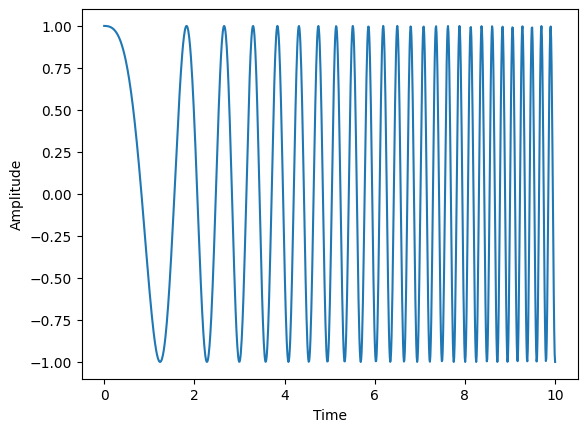

In [ ]:
# generate a signal
tt = np.linspace(0, 10, 1024)
sweep = ssg.chirp(tt, f0=0.1, f1=5, t1=10)

plt.plot(tt, sweep)
plt.xlabel("Time")
plt.ylabel("Amplitude")

In general FFTs operate on complex numbers, but in this case the data is purely real. That means there is some symmetry in the transform that can be exploited for efficiency, which we can get by calling the `rfft` real-number version of the function rather than the more general `fft`:

In [ ]:
ff = fft.rfft(sweep)

We'll look at the transformed version in a moment, but first note that the transform is invertible. We can easily recover the original signal from it by calling the inverse function — `irfft` here, or `ifft` for the general case.

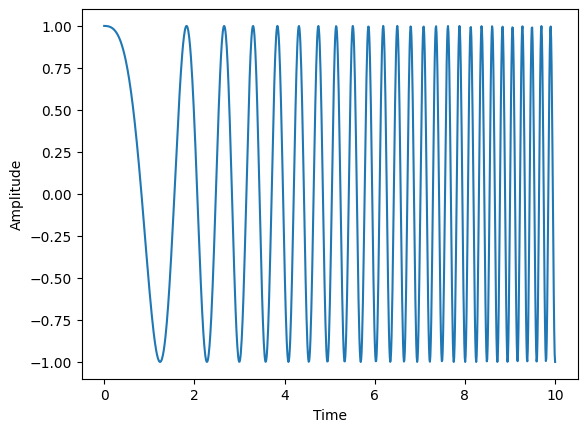

In [ ]:
recovered = fft.irfft(ff)

plt.plot(tt, recovered)
plt.xlabel("Time")
plt.ylabel("Amplitude")

assert(np.allclose(sweep, recovered))

Unlike the original signal, the frequency domain version is complex. It's a 1D signal, but it differs from our original in length:

In [ ]:
print(ff.dtype, ff.shape)

complex128 (513,)


The actual contents of the array are a bit opaque. Each entry represents a single frequency component. The magnitude of the complex number at that point represents the amplitude of that frequency in the original signal, while the angle represents its phase.

Text(0.5, 0, 'Frequency Index')

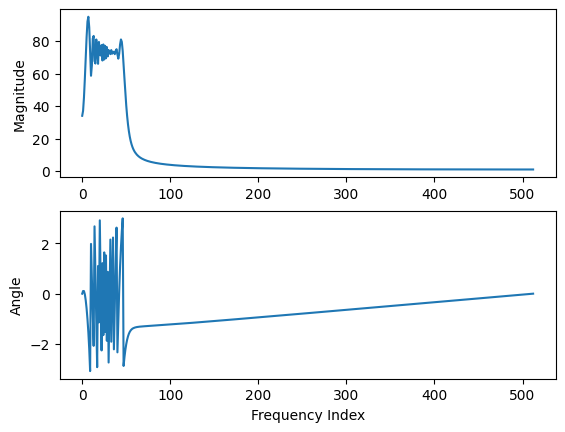

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(np.absolute(ff))
axs[0].set_ylabel("Magnitude")
axs[1].plot(np.angle(ff))
axs[1].set_ylabel("Angle")
axs[1].set_xlabel("Frequency Index")

We can sort of see a shape here, but it's a bit hard to interpret. It looks like the magnitude drops near to zero for higher frequencies, which makes sense given the original signal was a low frequency cosine sweep. But beyond that, these graphs are a little opaque. We're usually better off with dedicated spectrum plotting functions like this:

In [ ]:
# we pass the sampling frequency so the spectrum
# can have meaningful frequency values
sample_freq = len(tt)/tt[-1]

plt.magnitude_spectrum(sweep, Fs=sample_freq);

Note that we pass the original signal here, not the transformed version. Under the hood this will compute the FFT much like we did, but it then arranges and presents the data for readability rather than computational efficiency.

Similarly for the phase:

In [ ]:
plt.phase_spectrum(sweep, Fs=sample_freq);


As mentioned in week 1, human hearing is quite insensitive to phase, so while the phase is important for signal reconstruction, we'll often ignore it. In this case, though, the spectrum makes sense given the sweep form that we know is in the signal.

A popular way of representing the frequency distribution in a signal is with its **power spectrum** or [power spectral density](https://en.wikipedia.org/wiki/Spectral_density), which considers the **power** in each component rather than its amplitude, averaged over all time. (By default MatPlotLib displays this with a log scale on the vertical axis, which compresses the peaks and expands the shallow bottom, which can help make the shape more apparent. It is possible to do a similar thing with the other plots, as we'll see below.)

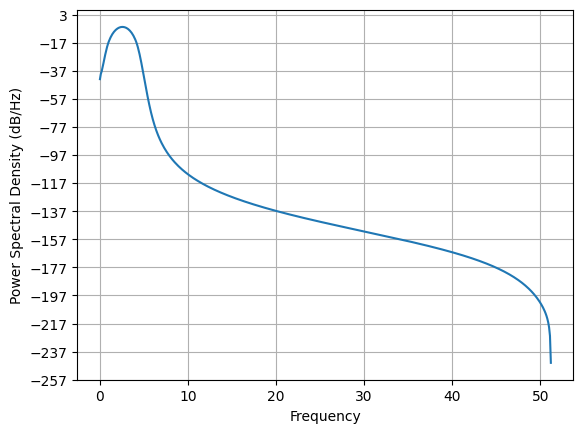

In [ ]:
plt.psd(sweep, Fs=sample_freq, NFFT=1024);

So far we've taken the FFT of a whole signal, but this can be computationally expensive for long signals, plus you have to wait until all the data is available. Moreover, the result is a single monolithic spectrum, but often we'll be interested in looking at how the frequency distribution changes over time.

An alternative is to calculate the FFT in smaller chunks, producing what is known as a [short time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT).

(The `NFFT` argument to the `psd` plot above specifies this kind of chunking — the power spectrum is then averaged over all the chunks. However, in our example we specified `NFFT` to be the whole length of the signal, so only a single FFT was computed.)

The STFT can be visualised as a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram):


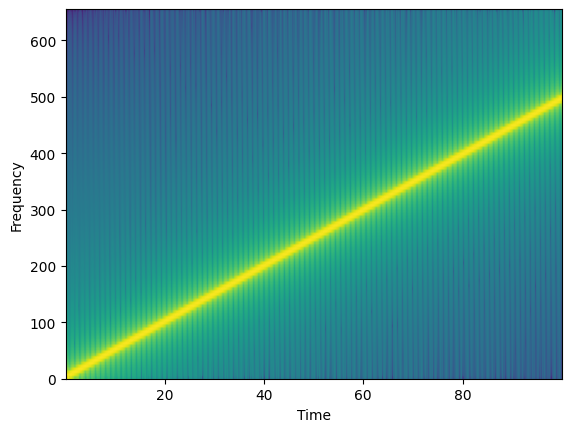

In [ ]:
# generate a longer signal here so we actually have enough
# chunks to be worth plotting
long_time = np.linspace(0, 100, 1024 * 128)
long_sweep = ssg.chirp(long_time, f0=1, f1=500, t1=100)

plt.specgram(long_sweep, Fs=len(long_time)/long_time[-1])
plt.xlabel("Time")
plt.ylabel("Frequency");

The spectrum for each chunk is plotted as a single column in the plot, using colour or brightness to represent the magnitude for each frequency. In this example, we can clearly see that there is a single frequency peak (in yellow) that sweeps upwards over time. That definitely seems more informative than the aggregate spectrum for the entire signal:

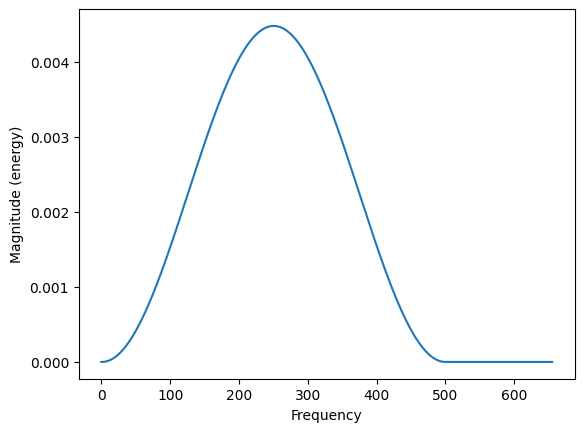

In [ ]:
plt.magnitude_spectrum(long_sweep, Fs=len(long_time)/long_time[-1]);

We can also **listen** to this signal. But the nominal sampling rate specified for the spectrogram is rather low, so we'll arbitrarily shift it to something more audio-appropriate.

**NB: Always be cautious when playing synthetically generated sounds like this. Start with your audio volume turned down low!**

In [ ]:
display(Audio(long_sweep, rate=22050))

The range of detectable frequencies depends on the chunk (or window) size. An STFT with a short window has a constrained resolution, but is faster to compute. It also has lower **latency** — the amount of time you have to wait for it. STFTs with reasonably short windows can be applied in near real time, giving immediate feedback to the user. (We saw some examples of this in week 1.)

# Filtering

We will often want to modify the frequency composition of a signal, whether for technical reasons — eg, to remove high frequencies that our sampling rate cannot capture, which would otherwise alias — or aesthetic ones — ie, to make it sound better. Such modifications fall into the domain of **filtering**. Broadly, a **filter** is a device or process that adjusts the spectrum of a signal.

Physical sounds are filtered all the time, by the properties of the materials they are passing through and the environment they are in, by the anatomical structures of the ears. The brain is sensitive to such nuances. Changes in the balance of frequencies can make a sound thin and reedy or deep and rich, harsh or mellow, bright or dark. They can make sonic details stand out or get lost in the mix. These variations carry information, emotional resonance, meaning.

So filters are essential for sound recording, analysis and reproduction. Many different kinds have been developed over the years, both for analogue signals and subsequently digital, with a wide range of underlying implementations. But most fall into a small number of basic types, or are built up from combinations of those.

For the moment we'll gloss over the question of implementation and just look at what each type does. Let's first create some simple example signals with which to demonstrate.

**White noise** is data with no regular structure, in which all frequencies are present in roughly equal amounts. We can approximate this by drawing from a random distribution.

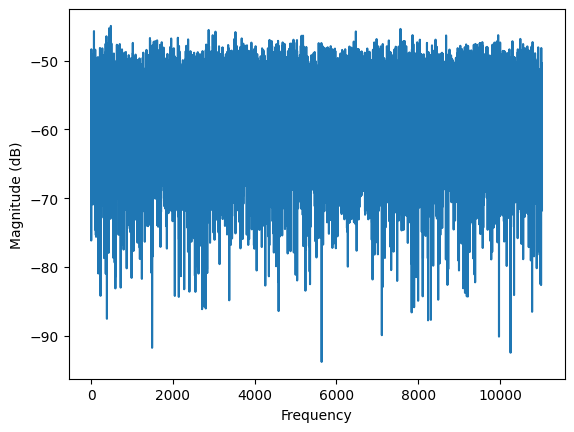

In [ ]:
# at sample rate of 22050 this will be 2 seconds long
noise = np.tanh(rng.normal(scale=0.33, size=44100))
plt.magnitude_spectrum(noise, Fs=22050, scale='dB');

<details>
<summary>Implementation detail</summary>
<p>By convention, audio data represented as floating point numbers should be kept in the range [-1, 1]. Many systems will cope if this is not the case, others may behave oddly or make horrible noises.
</p><p>
Here we're generating Gaussian noise with mean 0 and standard deviation 0.33, which will concentrate in the desired region but may take any value in [-∞, ∞]. We could just clip to the desired range, but instead we'll apply the hyperbolic tangent function <tt>tanh</tt> to *compress* the infinite range into [-1, 1]. We'll talk a bit more about compression in a future tutorial.
</p>
</details>

As you can see from the plot, the spectrum is pretty flat. There is some random variation, but nothing systematic.

We can again listen to this signal — you can probably guess what it sounds like.

In [ ]:
display(Audio(noise, rate=22050))

We'll also create some signals with known frequency content. These are all tones with a pitch of 392 Hz, approximately the musical note G4.

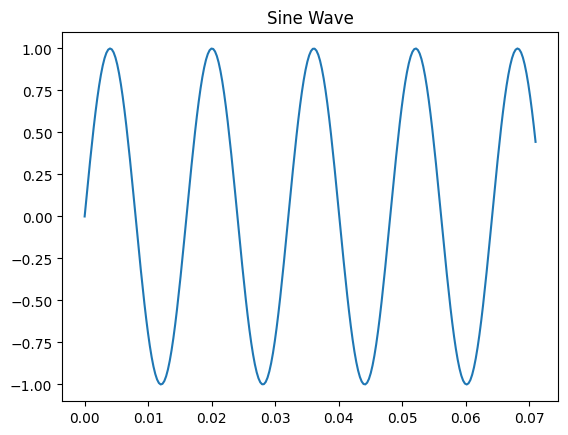

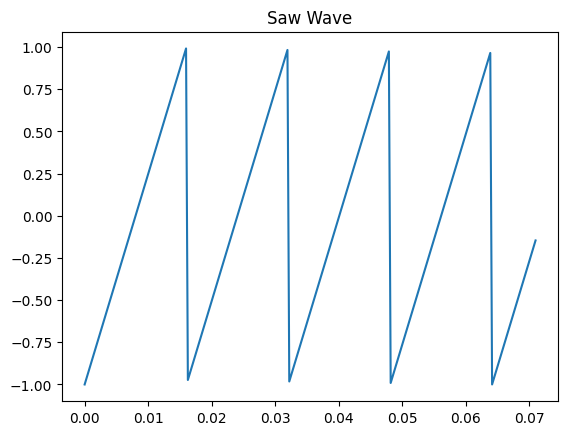

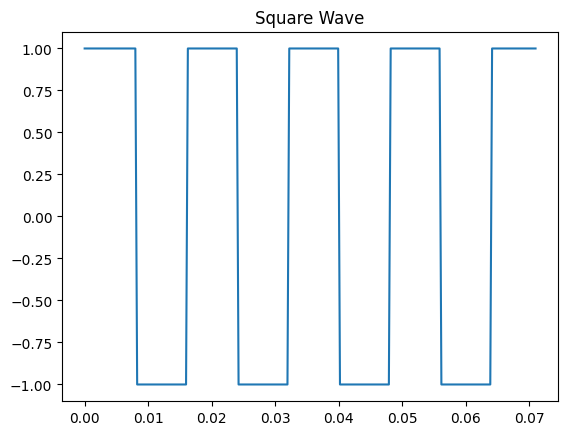

In [ ]:
# time base for a 2s 1Hz sinusoid at the 22050 sampling rate
tt = np.linspace(0, 4 * np.pi, 44100)

# roughly G4
PITCH = 392

# single tone
sine = np.sin(tt * PITCH)

# sawtooth wave at the same pitch
saw = ssg.sawtooth(tt * PITCH)

# and a square wave, why not?
square = ssg.square(tt * PITCH)

# plot snippets of each to illustrate
SNIP = 250
plt.plot(tt[:SNIP], sine[:SNIP])
plt.title("Sine Wave")
plt.figure()
plt.plot(tt[:SNIP], saw[:SNIP])
plt.title("Saw Wave")
plt.figure()
plt.plot(tt[:SNIP], square[:SNIP])
plt.title("Square Wave");

In [ ]:
display(Audio(sine, rate=22050))
display(Audio(saw, rate=22050))
display(Audio(square, rate=22050))

Although these tones are all the same nominal pitch, they sound different because they contain different mixtures of frequencies.

The sine wave is pretty much just one single frequency, with a tiny bit of high frequency noise due to discretisation. (This might look significant, but it's really exaggerated by the log scaling — a magnitude of -250 dB is *very* small.)

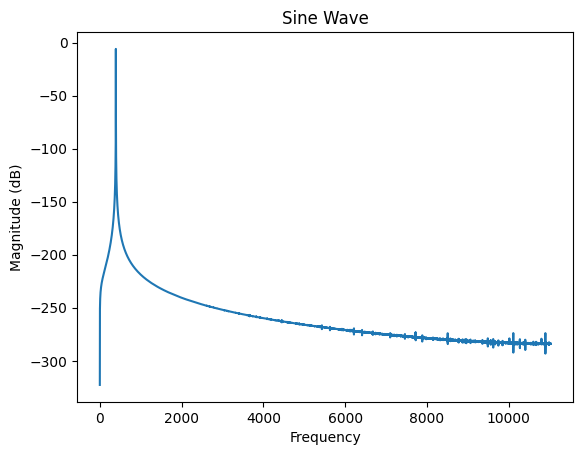

In [ ]:
plt.magnitude_spectrum(sine, Fs=22050, scale='dB');
plt.title("Sine Wave");

Saw and square waves both contain a large number of other components, known as **harmonics** or **overtones**. These are multiples of the base frequency at diminishing amplitudes, which sum together to build the sharp corners of the wave out of smoothly flowing sines. These can be seen as periodic peaks in the spectrum:

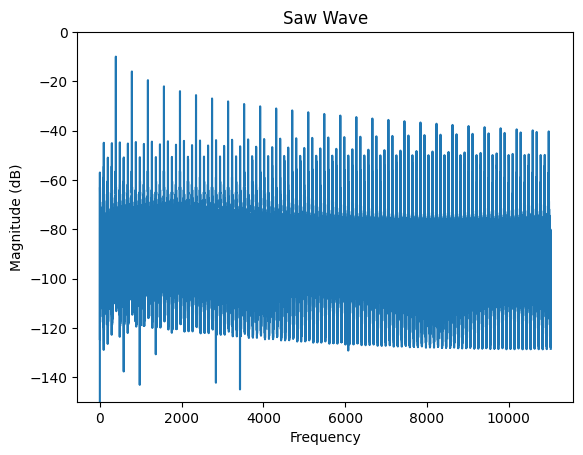

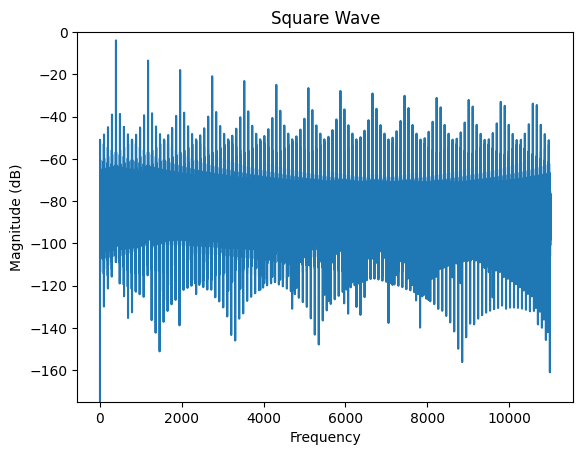

In [ ]:
plt.magnitude_spectrum(saw, Fs=22050, scale='dB')
plt.title("Saw Wave")
plt.ylim(-150, 0)
plt.figure()
plt.magnitude_spectrum(square, Fs=22050, scale='dB')
plt.ylim(-175, 0)
plt.title("Square Wave");

Notably, these saw and square waves are not **band-limited** — they contain an infinite number of harmonics, reaching infinitely high frequencies. Obviously these are above the maximum frequency that can be captured at our 22kHz sampling rate, and so they get aliased, producing spurious lower frequency peaks in the spectrum. These extra peaks are quite visible in the plots, zigzagging back and forth into the frequency range. These aliased harmonics can be heard as discordant tones in the sound, adding a sort of background buzz.

We can create band-limited versions of these signals by **additive synthesis** — explicitly building the waveform out of the subset of harmonics that fit into the sampling frequency.

Here is an example for the saw wave. Don't worry too much about the details of this, it is really just for illustration.

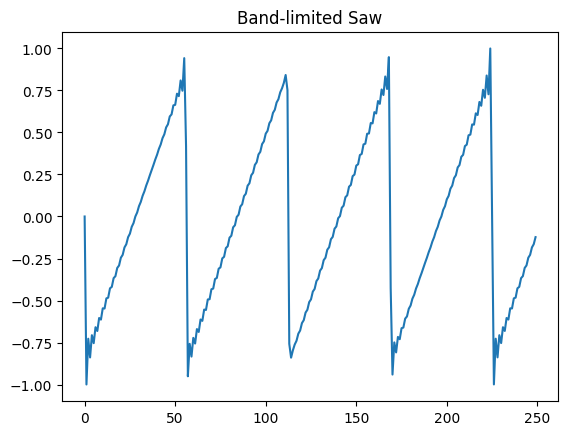

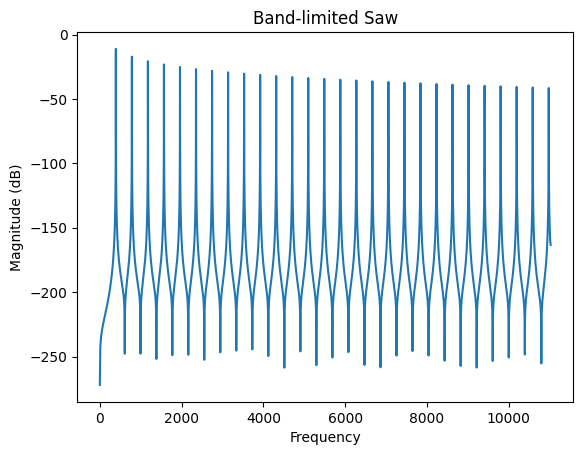

In [ ]:
def bandlimited_saw ( N, freq=PITCH, fs=22050 ):
  """
  Generate a band-limited sawtooth wave of length `N`,
  with fundamental frequency `freq` at sampling rate `fs`.
  """
  assert(freq < fs/2)

  tt = np.linspace(0, 2 * np.pi * N / fs, N)
  max_harm = int(np.floor(fs / (2 * freq)))

  # start with the fundamental
  result = -np.sin(tt * freq)

  # add the harmonics
  for harm in range(2, max_harm + 1):
    result -= np.sin(tt * freq * harm) / harm

  # scale into [-1, 1]
  result = 2 * (result - np.min(result))/(np.max(result) - np.min(result)) - 1

  return result


bl_saw = bandlimited_saw ( 44100 )
plt.plot(bl_saw[:SNIP])
plt.title("Band-limited Saw")
plt.figure()
plt.magnitude_spectrum(bl_saw, Fs=22050, scale='dB')
display(Audio(bl_saw, rate=22050))
plt.title("Band-limited Saw");

We can see that it's a slightly wobbly approximation of the full saw wave, but its spectrum is much cleaner. There is negligible higher frequency content, and hence no aliased peaks. The audible buzz in the background of the original saw wave is mostly absent here.

## Low Pass

As the name suggests, **low pass** filters allow low frequencies to pass through but attenuate higher frequencies. Anti-aliasing filters are generally of this type (but see discussion below).

Low pass filters are characterised by their **cutoff frequency** and **roll off**. Frequencies below the cutoff are known as the **passband** and ideally remain unchanged by the filter. Those above the cutoff are the **stop band**, and are attenuated according to the roll off.

Filters are not all or nothing, imposing a hard barrier at the cutoff. Instead, there is a graduated attenuation that increases with frequency. So frequencies just above the cutoff are attenuated a little bit, while much higher frequencies are attenuated much more. The roll off describes the rate of this increase, in units such as dB per octave. The simplest filters (known as **first order**) tend to have a roll off of 6 dB per octave, while more complex filters will roll off more steeply. (6 db per octave basically means that as the frequency doubles, so does the attenuation — in terms of *amplitude*, that is. The *power* attenuation quadruples.)

In practice, filters will often not achieve this ideal behaviour. The passband may not be perfectly flat, and the roll off may not be perfectly uniform. The true behaviour can described by the **frequency response** of the system, often presented as a plot like the one below.

`scipy.signal` provides a range of different filter types and we'll use one of these to demonstrate, a five pole [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter). We'll pick a cutoff frequency at the fifth harmonic. (Again, don't worry about the implementation details here.)

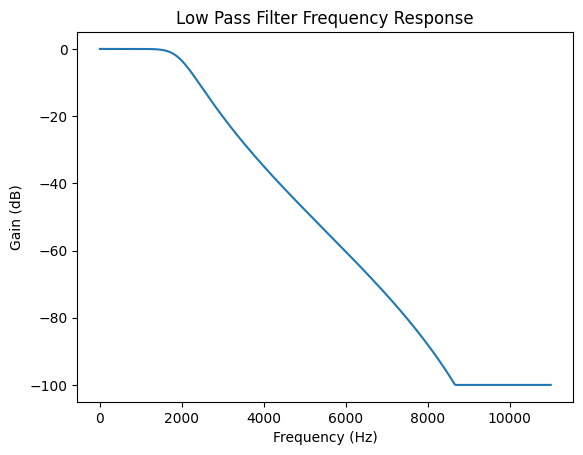

In [ ]:
lpf = ssg.butter(5, PITCH * 5, 'lowpass', fs=22050, output='sos')
w, h = ssg.sosfreqz(lpf, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Low Pass Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");

You can see from the graph that the frequency response is pretty flat in the passband and the roll off is fairly smooth and quite steep. (In fact, having a flat passband is a key feature of Butterworth filters.)

Let's try applying this filter to our signals. The noise has roughly equal amounts of all frequencies, so we'd expect its filtered spectrum to look quite a lot like the frequency response curve.

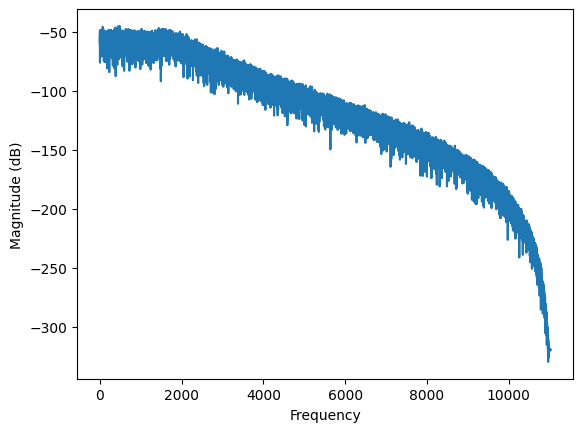

In [ ]:
noise_lpf = ssg.sosfilt(lpf, noise)
display(Audio(noise_lpf, rate=22050))
plt.magnitude_spectrum(noise_lpf, Fs=22050, scale='dB');

Although still just noise, the sound is audibly deeper, with less high frequency hiss.

Our 392 Hz sine wave is well below the cutoff frequency and the signal contains almost no higher harmonic content, so we'd expect it to pass pretty much unchanged.

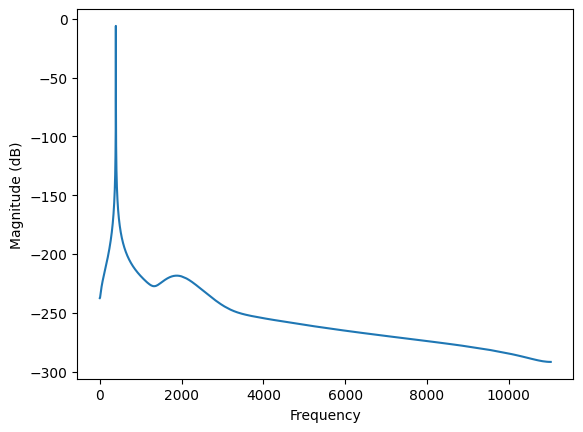

In [ ]:
sine_lpf = ssg.sosfilt(lpf, sine)
display(Audio(sine_lpf, rate=22050))
plt.magnitude_spectrum(sine_lpf, Fs=22050, scale='dB');

This is indeed the case. We can see from the spectrum that the filter has introduced a little bump around the cutoff frequency, but again this is exaggerated by the log scale. The effect is actually very small, and you'd be hard pressed to hear it in the sound.

By contrast, the saw and square waves contain lots of harmonics above the cutoff frequency, and these get attenuated quite a bit, audibly changing the sound.

In [ ]:
saw_lpf = ssg.sosfilt(lpf, saw)
display(Audio(saw_lpf, rate=22050))
plt.magnitude_spectrum(saw_lpf, Fs=22050, scale='dB');

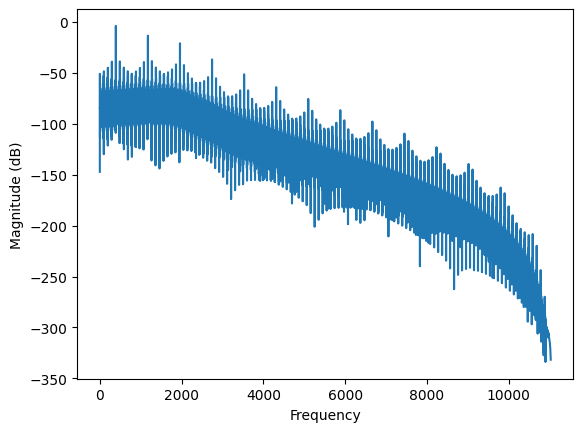

In [ ]:
square_lpf = ssg.sosfilt(lpf, square)
display(Audio(square_lpf, rate=22050))
plt.magnitude_spectrum(square_lpf, Fs=22050, scale='dB');

The filtering reduces the aliased harmonics above the cutoff along with all the other high frequencies, but it can't eliminate them completely — and those below the cutoff remain unchanged. The aliased frequencies are just some low frequencies present in the sample data, the filter can't distinguish them as aliased and single them out for special treatment.

For comparison, here's the band-limited version:

In [ ]:
bl_saw_lpf = ssg.sosfilt(lpf, bl_saw)
display(Audio(bl_saw_lpf, rate=22050))
plt.magnitude_spectrum(bl_saw_lpf, Fs=22050, scale='dB');

This gives the desired result, since there are no aliased frequencies present in the first place.


## Anti-Aliasing

If we can't reliably remove aliased frequencies from the signal once they are present, in what sense is a low pass filter useful for anti-aliasing?

The answer is that, as far as possible, we need to filter out the higher frequencies from the analogue signal *before* sampling it. (Or, if we are originating the signal digitally, as in the additive synthesis example, take care not to put them there in the first place.)

Digital audio recorders and sampling equipment will typically implement *some* form of analogue filtering before data capture, if only as a corollary of suppressing noise transients. Some may also include more comprehensive anti-alias filters for the analogue signal, but most modern analogue to digital converters (ADCs) take a different approach. These **delta-sigma** ($\Delta\Sigma$) ADCs trade numerical resolution for sampling rate, capturing data at very high frequency but only a single bit at a time. The resulting **oversampled** signal is then **downsampled** to the final, much lower, rate. A large number of single bit samples are aggregated into each higher resolution output sample, and in the process they are — digitally — low pass filtered.

(This is well beyond the scope of this module and we won't say more about it here, but if you're interested have a look at these documents from Texas Instruments: [How delta-sigma ADCs work, part 1](https://www.ti.com/lit/an/slyt423a/slyt423a.pdf) and [part 2](https://www.ti.com/lit/an/slyt438/slyt438.pdf).)

## High Pass

A **high pass** filter is the converse of a low pass, passing frequencies above the cutoff and rolling off those below. High pass filters are used for elimimating unwanted low frequency components such as [DC offset](https://en.wikipedia.org/wiki/DC_bias), baseline drift and rumble.

As before, we'll demonstrate with a five-pole Butterworth filter.

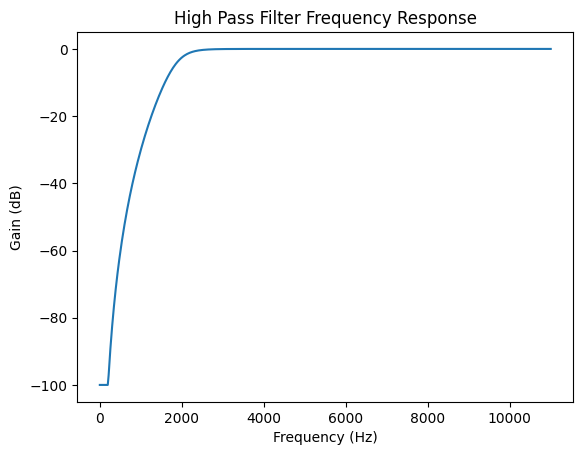

In [ ]:
hpf = ssg.butter(5, PITCH * 5, 'highpass', fs=22050, output='sos')
w, h = ssg.sosfreqz(hpf, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("High Pass Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");

Again, this filter has a characteristically flat passband, and rolls off quite steeply. When applied to the white noise we get a spectrum similar to the ideal response, and the audio is higher and hissier, with virtually all the bass taken out.

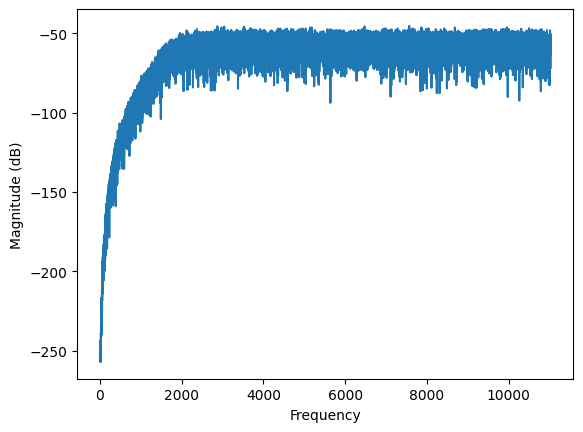

In [ ]:
noise_hpf = ssg.sosfilt(hpf, noise)
display(Audio(noise_hpf, rate=22050))
plt.magnitude_spectrum(noise_hpf, Fs=22050, scale='dB');

Our sine wave is now far below the cutoff frequency and firmly in the stop band. It is not *completely* blocked — there's still a peak in the spectrum — but is reduced to the point of inaudibility.

<details>
<summary>Note</summary>
If you've been looking at the code you might notice an unfamiliar argument here: <tt>normalize=False</tt>. By default, the Audio class will scale the data to fit into the range [-1, 1], as is standard when representing sound. For our original sine wave this doesn't make any difference, since it already occupies that range. For the attenuated version it makes it louder, which gives a misleading impression of the filter results. In this case we turn off the normalisation in order to hear — or not hear — the proper output. Feel free to try it both ways.
</details>

In [ ]:
sine_hpf = ssg.sosfilt(hpf, sine)
display(Audio(sine_hpf, rate=22050, normalize=False))
plt.magnitude_spectrum(sine_hpf, Fs=22050, scale='dB');

The other wave forms have harmonics above the cutoff, so sound comes through, but higher and thinner having lost the bass frequencies. Again, aliased harmonics remain in the non band-limited versions, and were never present in the band-limited saw. In practice these are less noticeable than in the original and low-pass versions, because the low frequency aliases were the most prominent and intrusive.

In [ ]:
saw_hpf = ssg.sosfilt(hpf, saw)
display(Audio(saw_hpf, rate=22050))
plt.magnitude_spectrum(saw_hpf, Fs=22050, scale='dB');

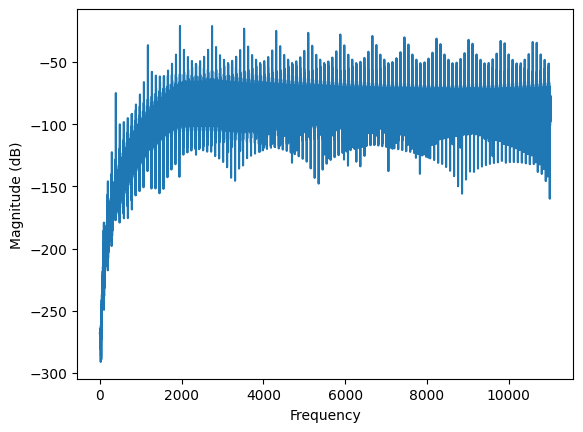

In [ ]:
square_hpf = ssg.sosfilt(hpf, square)
display(Audio(square_hpf, rate=22050))
plt.magnitude_spectrum(square_hpf, Fs=22050, scale='dB');

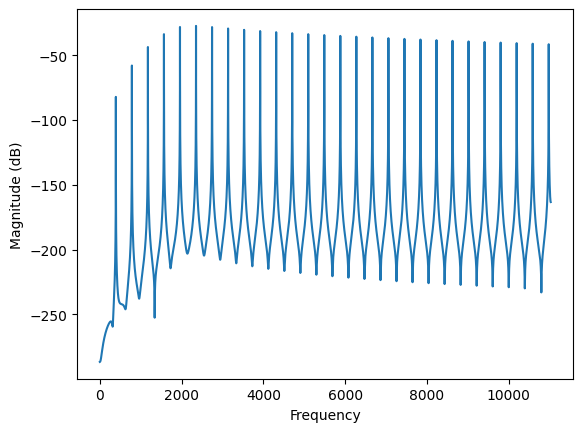

In [ ]:
bl_saw_hpf = ssg.sosfilt(hpf, bl_saw)
display(Audio(bl_saw_hpf, rate=22050))
plt.magnitude_spectrum(bl_saw_hpf, Fs=22050, scale='dB');

## Band Pass & Band Stop

*Band pass* filters are basically equivalent to applying both a low pass and a high pass filter to the same signal one after the other (and may sometimes actually be implemented that way). The passband for the filter includes everything above the high pass cutoff and below the low pass cutoff, while everything on either side gets rolled off:

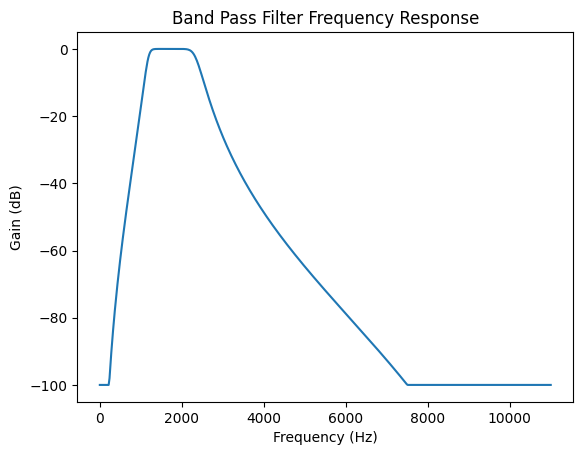

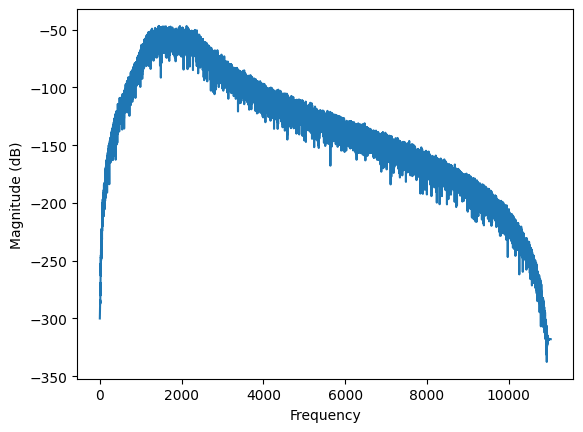

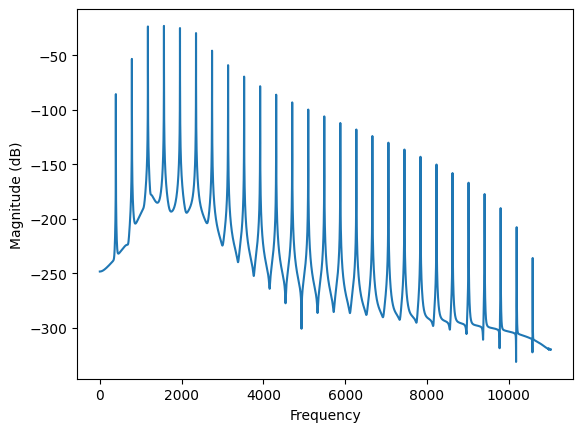

In [ ]:
bpf = ssg.butter(5, (PITCH * 3,PITCH * 6), 'bandpass', fs=22050, output='sos')
w, h = ssg.sosfreqz(bpf, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Band Pass Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");
plt.figure()
noise_bpf = ssg.sosfilt(bpf, noise)
display(Audio(noise_bpf, rate=22050))
plt.magnitude_spectrum(noise_bpf, Fs=22050, scale='dB')
plt.figure()
bl_saw_bpf = ssg.sosfilt(bpf, bl_saw)
display(Audio(bl_saw_bpf, rate=22050))
plt.magnitude_spectrum(bl_saw_bpf, Fs=22050, scale='dB');

Conversely, a **band stop** filter is equivalent to applying low pass and high pass filters *in parallel* and then combining the results. The passband contains everything below the low pass cutoff *and* everything above the high pass cutoff, and the range of frequencies in between are rolled off:

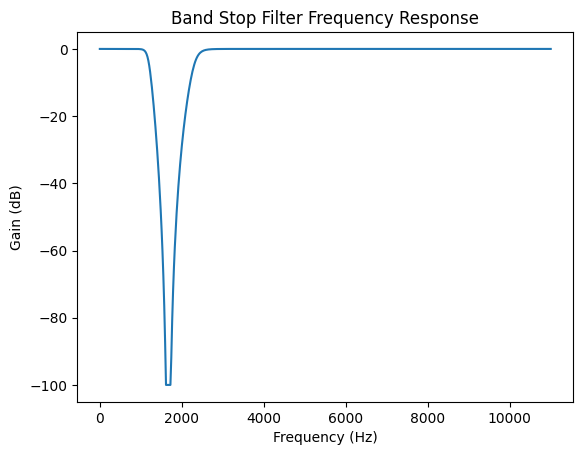

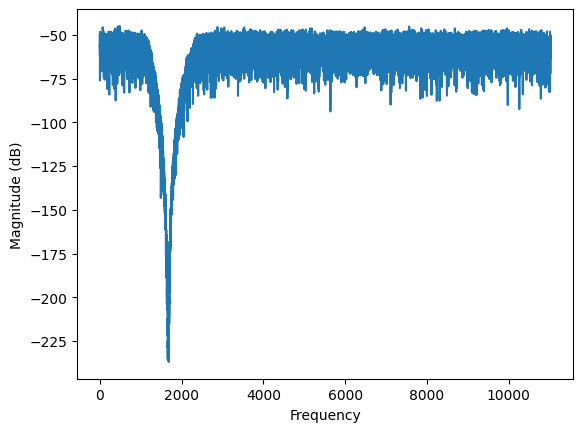

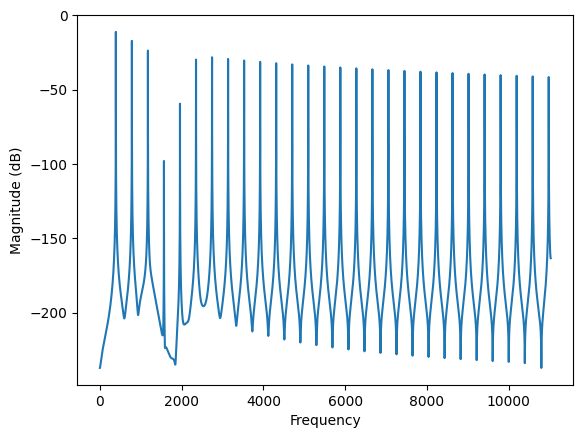

In [ ]:
bsf = ssg.butter(5, (PITCH * 3,PITCH * 6), 'bandstop', fs=22050, output='sos')
w, h = ssg.sosfreqz(bsf, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Band Stop Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");
plt.figure()
noise_bsf = ssg.sosfilt(bsf, noise)
display(Audio(noise_bsf, rate=22050))
plt.magnitude_spectrum(noise_bsf, Fs=22050, scale='dB')
plt.figure()
bl_saw_bsf = ssg.sosfilt(bsf, bl_saw)
display(Audio(bl_saw_bsf, rate=22050))
plt.magnitude_spectrum(bl_saw_bsf, Fs=22050, scale='dB');

Band stop filters are especially useful for suppressing systematic noise sources, such as [mains hum](https://en.wikipedia.org/wiki/Mains_hum).

Band pass filters are useful for dividing a signal up into different frequency bands. Properties of each band, such as volume level or stereo position, can then be adjusted independently before mixing them all back together — as in a [graphic equaliser](https://en.wikipedia.org/wiki/Equalization_(audio)#Graphic_equalizer).

Band pass and band stop filters may be characterised in terms of separate low and high pass cutoff frequencies (as in the code examples above), but are often instead specified by a single **centre frequency** (roughly the midpoint of the pass or stop band) together with its **bandwidth**. The latter is measured at the line where the gain is 0.5.

Some filters may also exhibit something called **resonance**. This is a natural feature of many of the electronic circuits used to implement analogue filters — especially "active" filters with amplifying stages — which tend to emphasise frequencies close to the cutoff. This can produce aesthetically pleasing effects and so is often reproduced in digital filters too — it turns out to emerge rather naturally from the implementation. (We'll see an example later.)

# Digital Filter implementation

Given that we can represent a signal in terms of its entire frequency composition by means of an FFT, and given that filtering is all about adjusting that frequency composition, it might seem natural to implement filters as operations in the frequency domain. Just compute the FFT, adjust the levels, compute the inverse, *et voilà!*

While that is indeed possible, it is almost never how digital filters are implemented in practice. There are several reasons for this, but it mostly boils down to efficiency.

Transforming to the frequency domain and back is computationally expensive. It also introduces significant latency, because you need a decent chunk of data in hand to run the FFT on. You can use an STFT with very short windows, but you'll have limited frequency resolution, with no real access to the lower frequencies that manifest over longer time scales. You'll also have to worry more about boundary effects at the window edges.

Happily, there are much more efficient approaches you can apply directly in the time domain, just by computing weighted sums of samples over some moving window on the signal.

The process is expressed by the following **difference equation**:

$$
y_t = \sum_{i=0}^P b_i x_{t-i} - \sum_{j=1}^Q a_j y_{t-j}
$$

<details>
<summary>Note</summary>
The subtraction of the second sum here is a convention, because it happens to be convenient for mapping to the transfer function mentioned below. You will often also see a normalising factor of $\frac{1}{a_0}$. For the purposes of this tutorial you don't need to worry about either of these things.
</details>

Here, $x_t$ is the input signal sample at time $t$, and $y_t$ is the output (filtered) sample that will be emitted at that time. Each $y_t$ is calculated as a weighted sum of the $P$ previous input samples (including the current one), weighted by coefficients $b_i$, and also (optionally) the $Q$ previously calculated output samples (obviously not including the current one, which we don't have yet), weighted by coefficients $a_j$. All the $a$s and $b$s are fixed and unchanging, making this a **linear time-invariant system**.

The **order** of the filter is $\max(P, Q)$ — ie, how far back in time the system looks. Higher order filters can have more complex frequency responses and steeper roll-offs.

If the $a_j$ are all 0 (or equivalently $Q=0$), the filter is said to have a **finite impulse response** (FIR): the effect of any input sample on the output is guaranteed to be of limited duration. After $P$ timesteps, it's gone, forgotten, never to be seen again.

If the filter has non-zero $a_j$, then it has an **infinite impulse response** (IIR). Because the output of the calculation feeds back to the next step, an input might have a very long term effect. (Consider a system with just $a_1 = -1$ and $b_0 = 1$. What will $y$ be?) IIR filters are very efficient — typically requiring many fewer coefficients and calculations than FIRs to achieve a comparable outcome — but they can also be **unstable**, leading to outputs that *blow up*.

These filters are easy to implement and usually fast to compute. They are not necessarily easy to *design*. It's not immediately obvious what combination of coefficients you need for, say, a low pass filter with a cutoff frequency of 300 Hz and a roll off of 12 db per octave. Fortunately, the mathematical and engineering basis of this is well established and everything you need for most purposes is readily available in libraries like SciPy.

All filters can be characterised by their **transfer function**, which defines the mapping of inputs to outputs, expressed in the frequency domain. For discrete filters, this is specifically the [Z domain](https://en.wikipedia.org/wiki/Z-transform), which can be thought of as an alternative *view* on the frequency space. (It's actually a superset of the space captured by the FFT, which maps to the unit circle in Z. You really don't need to care about this!)

It turns out that there's a neat relationship between the filter difference equation and its transfer function, and this can be used (with some limitations) to design filters. (I'm not going to go into detail here, but if you're interested [this video by Youngmoo Kim](https://youtu.be/xIN5Mnj_MAk) is quite accessible.)

For the purposes of SciPy functions, filters can be represented in three forms:

  * the difference equation coefficients **b** and **a** themselves
  * the transfer function's **zeros**, **poles** and **gain**, which determine the shape of the function in the Z domain
  * a decomposition into **second order sections**, a sequence of simpler filters that, when applied in turn, collectively produce the desired result

It is possible to specify any of these directly, but none of the representations is particularly intuitive. Usually you will instead want to use the various filter design functions that SciPy provides, which will figure out the above representations from some other criteria. The [`butter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) function used in the previous code sections is one such function. Here are a couple more.

[`iirfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) defines several different types of filters using a very similar parameterisation to `butter`, specifying one or two critical frequencies and the filter order. Indeed, Butterworth filters are one of the types it can create, but here let's try a [Bessel filter](https://en.wikipedia.org/wiki/Bessel_filter) instead:

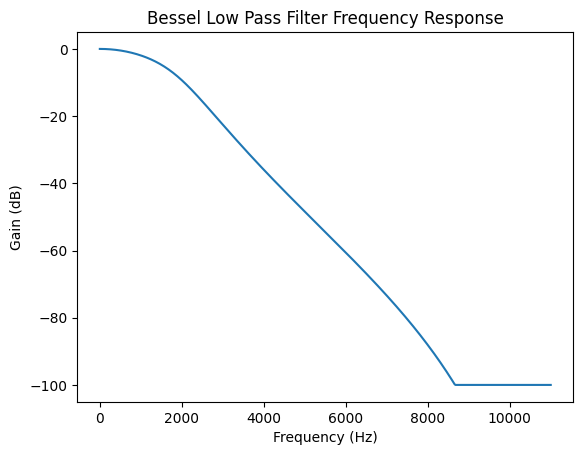

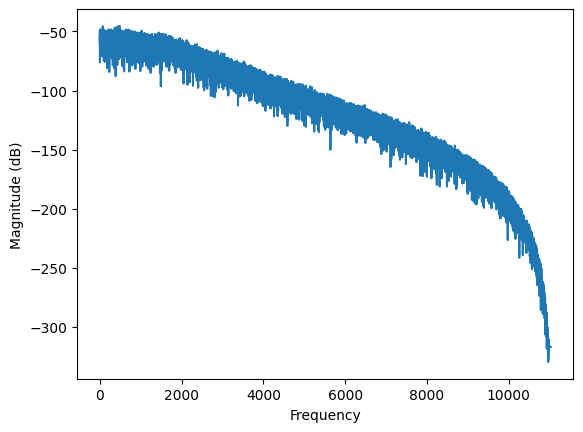

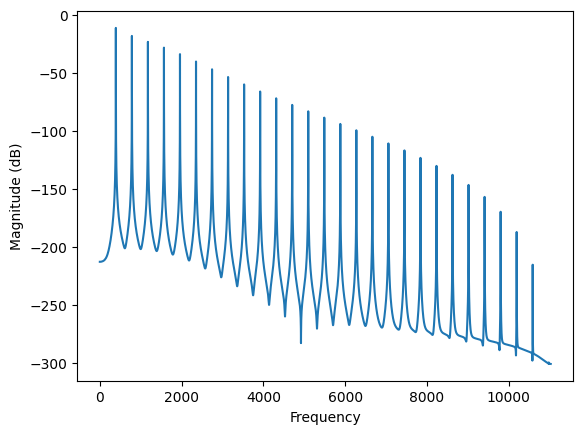

In [ ]:
bessel = ssg.iirfilter(5, PITCH * 5, btype='lowpass', output='sos', ftype='bessel', fs=22050)
w, h = ssg.sosfreqz(bessel, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Bessel Low Pass Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");
plt.figure()
noise_bessel = ssg.sosfilt(bessel, noise)
display(Audio(noise_bessel, rate=22050))
plt.magnitude_spectrum(noise_bessel, Fs=22050, scale='dB')
plt.figure()
saw_bessel = ssg.sosfilt(bessel, bl_saw)
display(Audio(saw_bessel, rate=22050))
plt.magnitude_spectrum(saw_bessel, Fs=22050, scale='dB');

Notably, the cutoff here is less sharp and the passband less flat than the Butterworth. Bessel filters prioritise a different aspect of the filter behaviour, the [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay), and sacrifice passband flatness for that.

[`iirdesign`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html) is similar, but you specify the requirements in a different way. Rather than explicitly setting the filter order, you specify the edge frequencies and gains of the pass and stop band, and the function will work out what filter order is needed. Again, it could be a Butterworth, but this time we'll try a [Chebyshev filter](https://en.wikipedia.org/wiki/Chebyshev_filter):

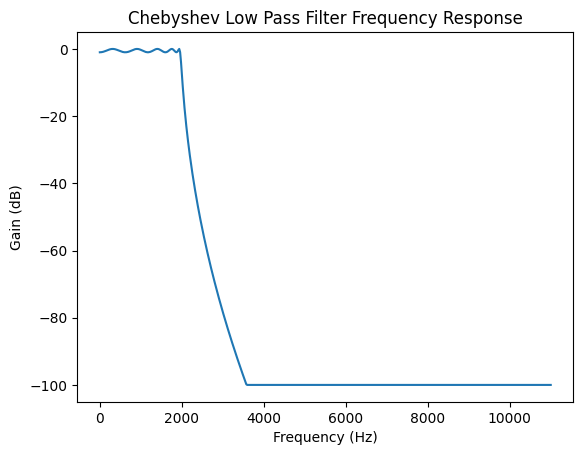

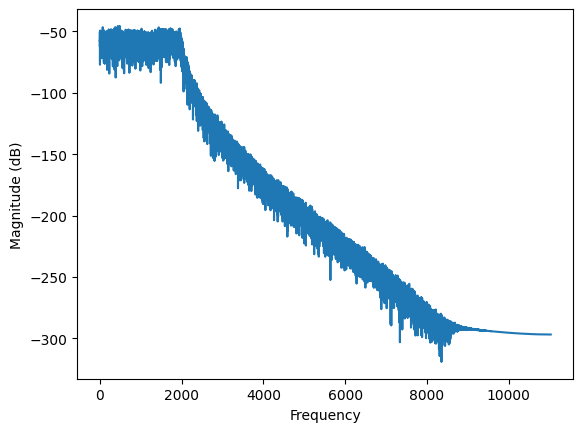

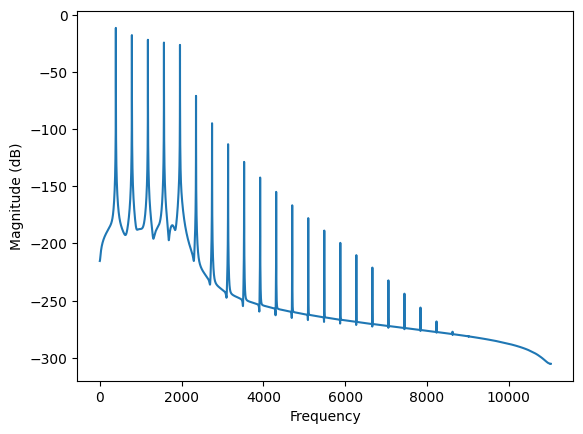

In [ ]:
cheb = ssg.iirdesign(wp=PITCH * 5, ws=PITCH * 6, gpass=1, gstop=40, output='sos', ftype='cheby1', fs=22050)
w, h = ssg.sosfreqz(cheb, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Chebyshev Low Pass Filter Frequency Response")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");
plt.figure()
noise_cheb = ssg.sosfilt(cheb, noise)
display(Audio(noise_cheb, rate=22050))
plt.magnitude_spectrum(noise_cheb, Fs=22050, scale='dB')
plt.figure()
saw_cheb = ssg.sosfilt(cheb, bl_saw)
display(Audio(saw_cheb, rate=22050))
plt.magnitude_spectrum(saw_cheb, Fs=22050, scale='dB');

Two things to notice about this: first, the passband has a distinct *ripple* — this is a characteristic of Chebyshev filters. Second, the roll-off is much steeper than the previous examples.

Chebyshev filters do indeed have a steeper roll-off than Butterworth and Bessel — trading off the passband ripple to achieve that — but in this case it's more down to the edge and gain settings. The passband ends at `PITCH * 5 = 1960`, close to the note B6, with gain of 1, while the stop band starts at `PITCH * 6 = 2352`, close to D7, just 3 semitones higher, with an attenuation of 40 dB. I'll leave the conversion to dB per octave as an exercise for the reader, but it's a lot!

To achieve this, the resulting filter must be higher order than the previous examples. We can check this with the [`cheb1ord`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheb1ord.html) function:

In [ ]:
ssg.cheb1ord(wp=PITCH * 5, ws=PITCH * 6, gpass=1, gstop=40, fs=22050)

(10, 1960.0)

The first number is the one of interest here: this is a 10th order filter, looking twice as far back in time as the 5th order ones we've looked at before.

We asked for the filter to be implemented as a set of second order sections (`output='sos'`). We can check how many there are:

In [ ]:
len(cheb)

5

This is actually pretty intuitive: each section contributes an order of 2, so to implement a 10th order filter we need 5 sections.

Butterworth, Bessel and Chebyshev filters are not the only kinds, but they are among the most common, and they illustrate the kinds of tradeoffs required in filter design.

## Second-Order Sections

Second order sections, also known as **biquads**, are time domain filters of order **2**:

$$
y_t = b_0 x_t + b_1 x_{t-1} + b_2 x_{t-2} - a_1 y_{t-1} - a_2 y_{t-2}
$$

<details>
<summary>Note</summary>
As before, don't worry too much about the minus signs.
</details>

Biquads are simple to implement and (comparatively) to reason about. They have a fixed, finite structure for which optimised implementations are available, and they are relatively numerically stable. And it turns out that higher order filters can be decomposed into a sequence of biquads (plus a single first order term for odd orders). For these reasons biquads are very widely used as building blocks for time domain filters in general — all of the examples above are implemented this way.

You probably will never need to care about this in practice, because libraries like SciPy have all the necessary plumbing built in. But just for fun, let's implement a simple biquad filter manually. We'll also take the opportunity to demonstrate what resonance looks like.

A useful resource for biquad filters is the [Audio EQ Cookbook](https://www.w3.org/TR/audio-eq-cookbook/), originally by Robert Bristow-Johnson and subsequently adapted by the Audio Working Group of the W3C. We'll use a "recipe" from that cookbook to determine the coefficients for a single biquad low pass filter with the same cutoff frequency and sampling rate as before, and with a resonant peak bandwidth of 1 octave.

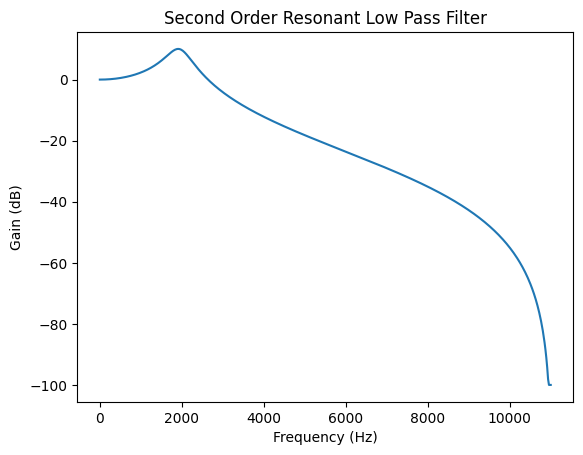

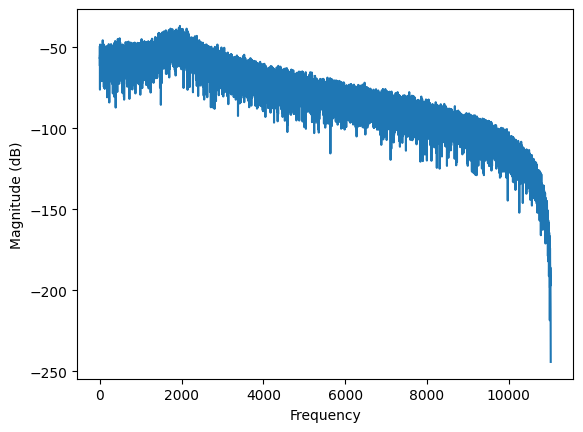

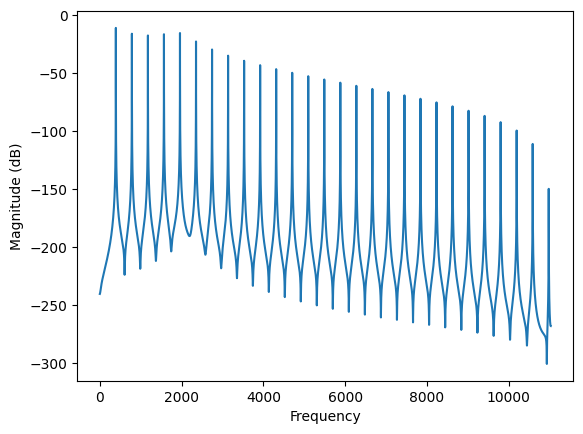

In [ ]:
# configuration
Fs = 22050
f0 = PITCH * 5
bw = 1

# intermediates
w0 = 2 * np.pi * f0 / Fs
sw0 = np.sin(w0)
cw0 = np.cos(w0)
alpha = sw0 * np.sinh(np.log10(2) * 0.5 * bw * w0 / sw0)

# low pass coefficients from the cookbook
b0 = (1 - cw0) / 2
b1 = 1 - cw0
b2 = b0
a0 = 1 + alpha
a1 = -2 * cw0
a2 = 1 - alpha

# scipy takes coefficients as a 2d array with 1 row per second order section
# we provide 6 coefficients per row, but they're expected to be normalised by a0
biquad = np.array([[b0, b1, b2, a0, a1, a2]]) / a0

w, h = ssg.sosfreqz(biquad, fs=22050)
plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
plt.title("Second Order Resonant Low Pass Filter")
plt.ylabel("Gain (dB)")
plt.xlabel("Frequency (Hz)");
plt.figure()
noise_biquad = ssg.sosfilt(biquad, noise)
display(Audio(noise_biquad, rate=22050))
plt.magnitude_spectrum(noise_biquad, Fs=22050, scale='dB')
plt.figure()
saw_biquad = ssg.sosfilt(biquad, bl_saw)
display(Audio(saw_biquad, rate=22050))
plt.magnitude_spectrum(saw_biquad, Fs=22050, scale='dB');


We can see that this filter actually amplifies the frequencies close to the cutoff frequency, only properly starting to roll off once it gets away from that resonant peak. This produces a noticeably different sound.

For comparison, here's the non-resonant low pass filtered saw again:

In [ ]:
display(Audio(bl_saw_lpf, rate=22050))